## Statistical Analysis of Grocery Data

### Importing Libraries

In [1]:
import pyodbc
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import sklearn.metrics as sm
from sklearn.cluster import KMeans

### Setting up connection with database

In [2]:
# set up connection parameters
server = '****'
database = 'GroceryStoreSimulator'
username = '*****'
password = "*****"

# establish connection
conn = pyodbc.connect(f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=Yes')

# create cursor
cursor = conn.cursor()


### Getting a list of columns in each table

In [5]:
cursor.execute("SELECT COUNT(TABLE_NAME) FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_TYPE = 'BASE TABLE'")
tabls = cursor.fetchall()
tabls

[(40, )]

In [3]:
# retrieve table names
cursor.execute("SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_TYPE = 'BASE TABLE'")

# loop through tables and get row count for each
for table in cursor.fetchall():
    table_name = table[0]
    #cursor.execute(f"SELECT COUNT(*) FROM {table_name}")
    cursor.execute(f"SELECT COLUMN_NAME, DATA_TYPE FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = '{table_name}'")

# print schema
    print(f"Schema for table {table_name}:")
    for column in cursor.fetchall():
        print(f"{column[0]} ({column[1]})", end = ", ")
   # row_count = cursor.fetchone()[0]
    #print(f"{table_name}: {row_count} rows")
    print("\n")


Schema for table tSupplyChain:
SupplyChainID (int), ProductID (int), ManufacturerID (int), Comment (nvarchar), 

Schema for table tUOM:
UOMID (int), UOM (nvarchar), 

Schema for table tCoupon:
CouponID (int), Coupon (nchar), CouponDescription (ntext), CouponSourceID (int), StartDate (date), ThroughDate (date), MinimumPurchaseRequirement (money), 

Schema for table tProduct:
ProductID (int), Status (nvarchar), UPC-E (nvarchar), UPC-A  (nchar), ManufacturerID (int), BrandID (int), InitialPricePerSellableUnit (money), NameID (int), Description (nvarchar), ContainerID (int), Size (float), Size_UOMID (int), I_Size (float), I_UOMID (int), Parent (nvarchar), Count (nvarchar), Endorsement(s) (nvarchar), Country (nvarchar), Prepared / Notes - Health Claims (nvarchar), Serving_Size (float), Serving_Size_UOMID (int), I_Serving_Size (float), I-Serving_Size_UOM (nvarchar), I-Serving_Size_UOMID (int), Pieces (nvarchar), Servings_Per_Container (float), Calories (float), Fat_Calories (nvarchar), Total

### Checking Product table and plotting scatterplot matrix

##### We checked with other tables and found this matrix the most informative

C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:100: UserWarning: Attempting to set identical left == right == 12.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:101: UserWarning: Attempting to set identical bottom == top == 12.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:91: UserWarning: Attempting to set identical left == right == 12.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list

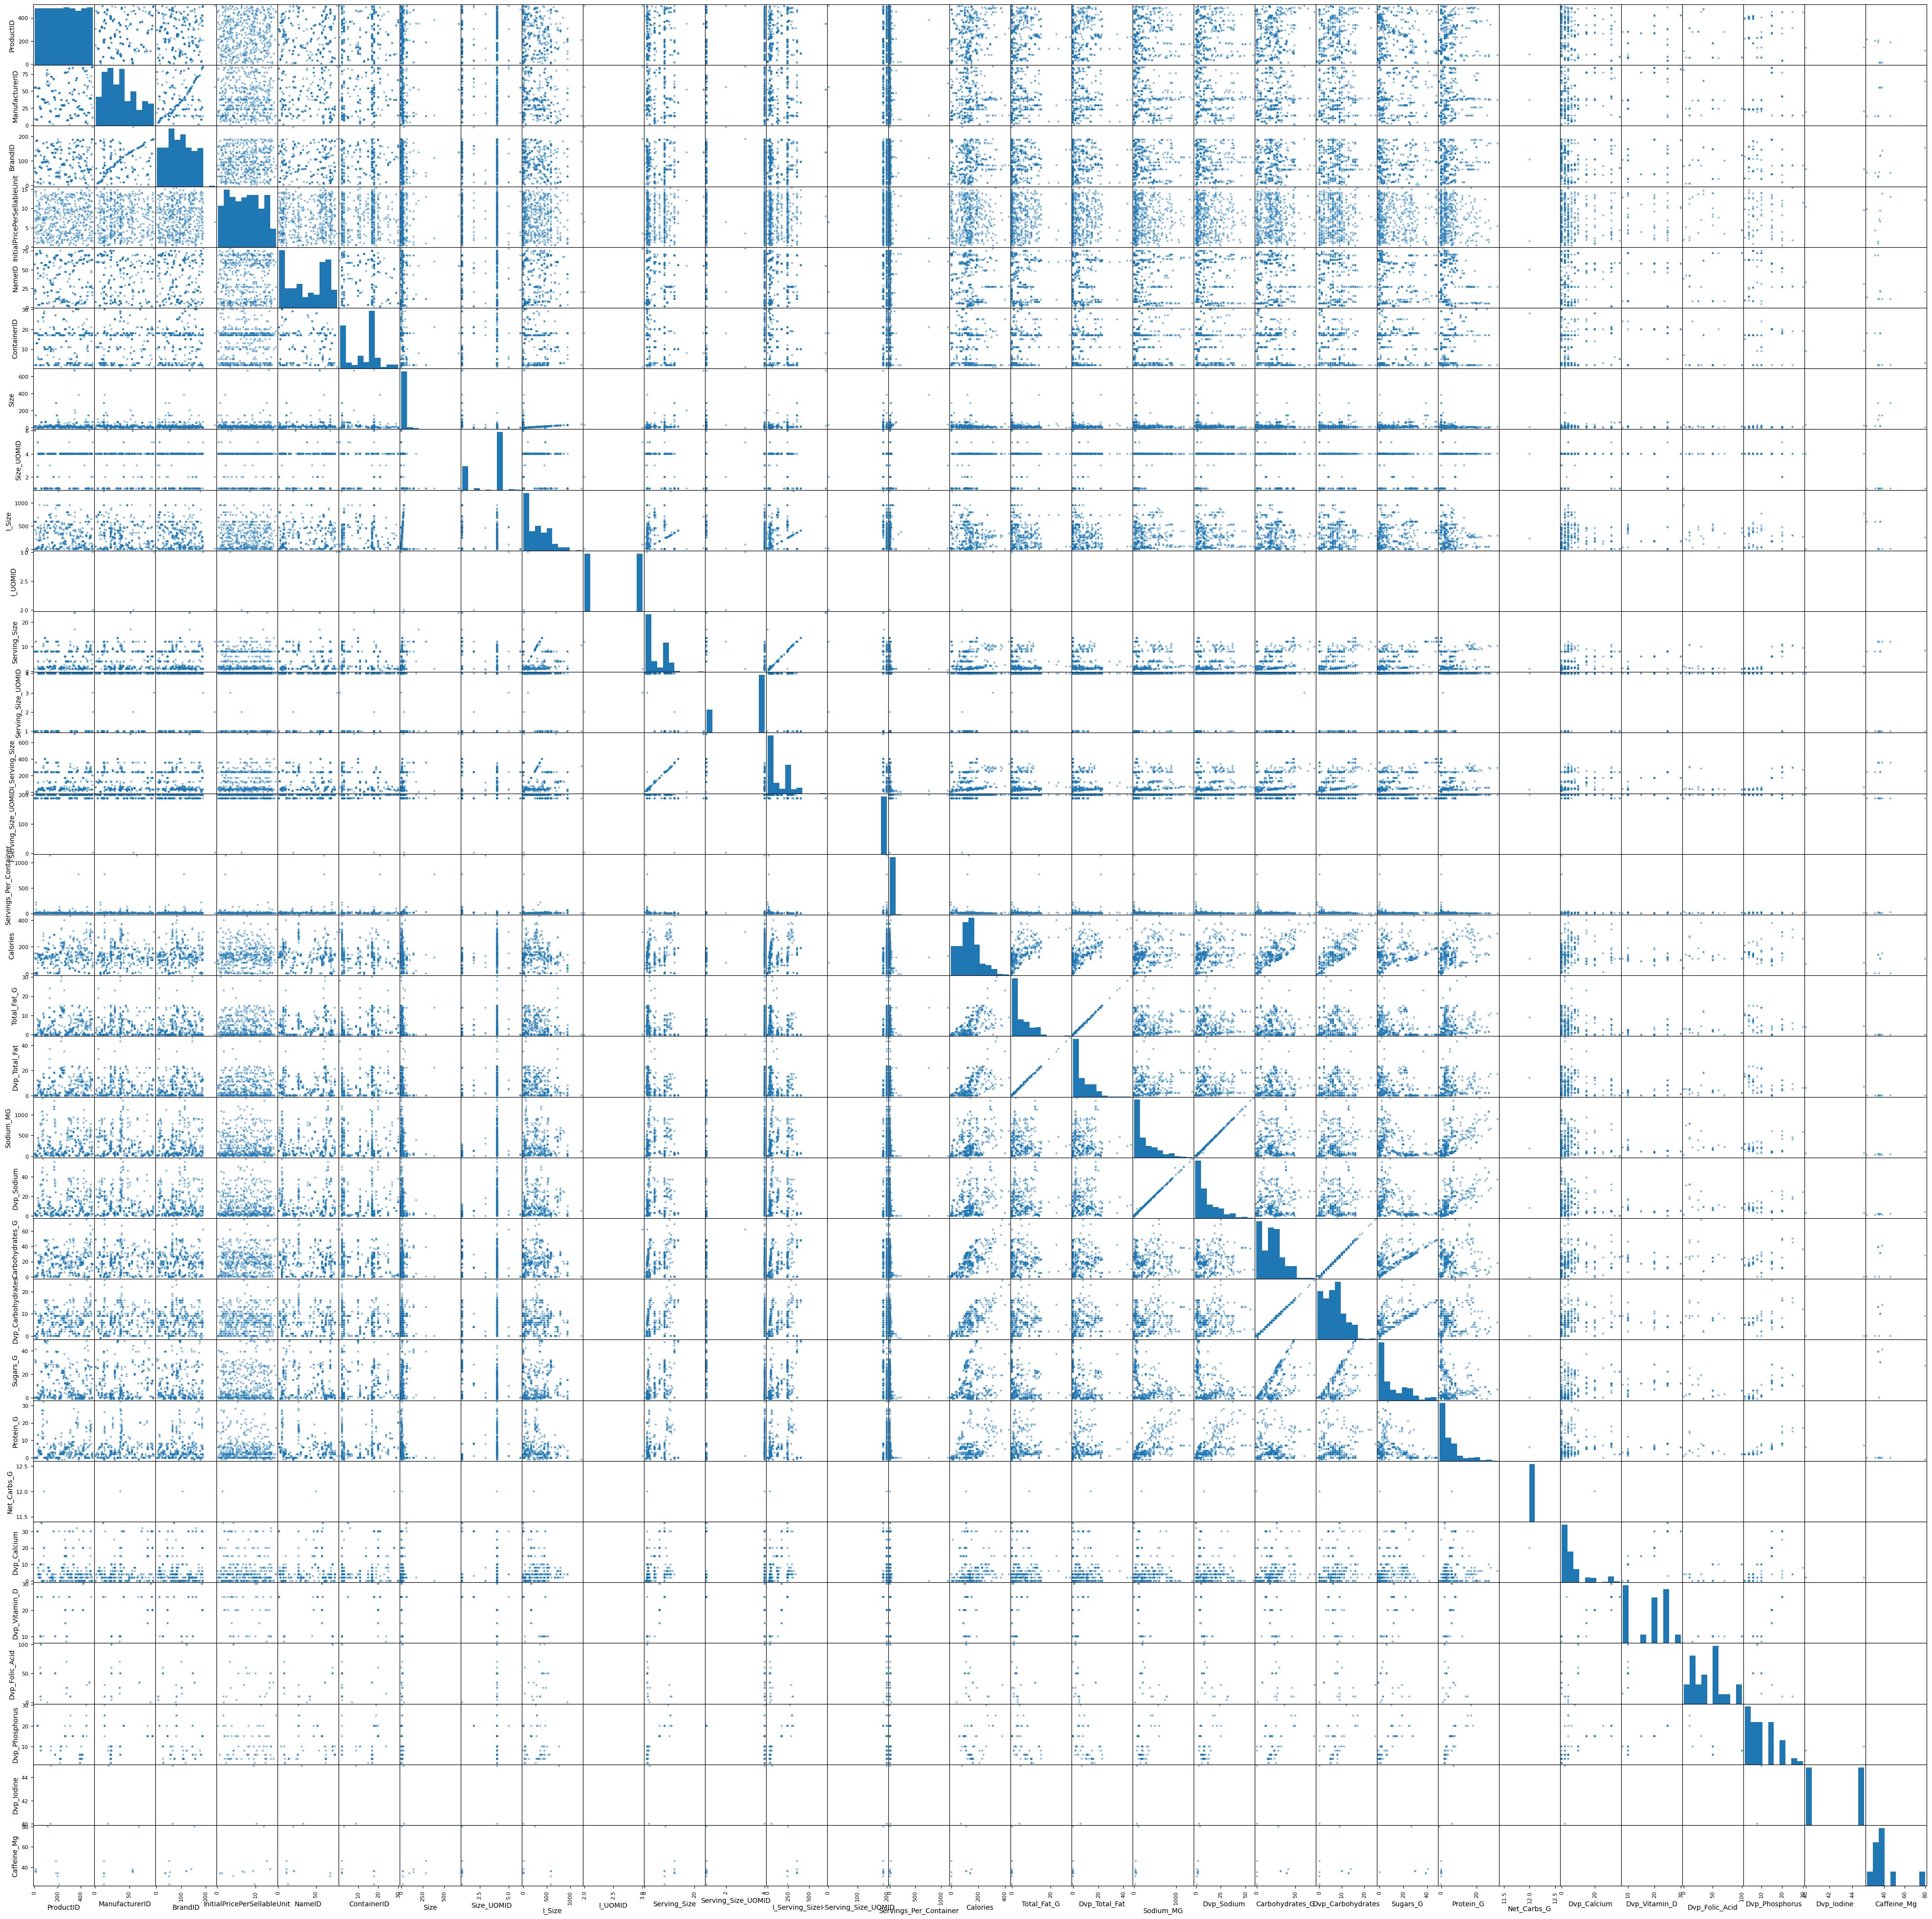

In [6]:
table_name = "tProduct"
column_names = '*'

# retrieve data from specified columns in specified table
dataframe = pd.read_sql_query(f"SELECT {','.join(column_names)} FROM {table_name}", conn)

# create scatter plot matrix
pd.plotting.scatter_matrix(dataframe, figsize=(50, 50), diagonal='hist')

# show plot
plt.show()

### Zomming in

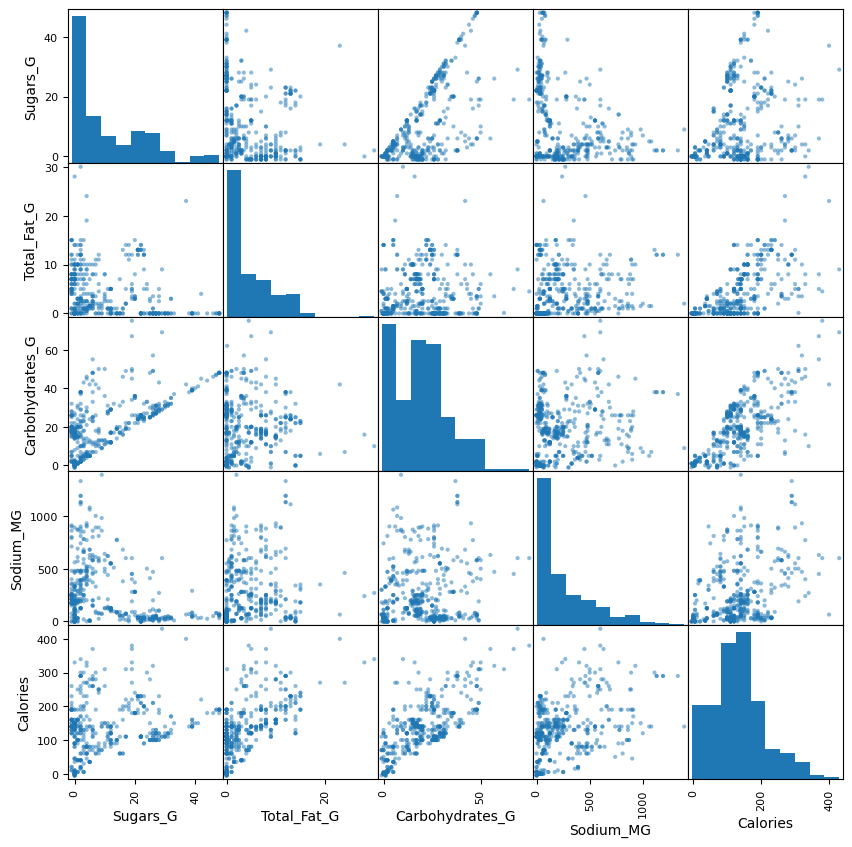

In [69]:
zoom_data = dataframe[['Sugars_G', 'Total_Fat_G', 'Carbohydrates_G', 'Sodium_MG','Calories']]

# create scatter plot matrix
pd.plotting.scatter_matrix(zoom_data, figsize=(10,10), diagonal='hist')

plt.show()

In [7]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 97 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ProductID                         500 non-null    int64  
 1   Status                            498 non-null    object 
 2   UPC-E                             498 non-null    object 
 3   UPC-A                             500 non-null    object 
 4   ManufacturerID                    500 non-null    int64  
 5   BrandID                           500 non-null    int64  
 6   InitialPricePerSellableUnit       500 non-null    float64
 7   NameID                            500 non-null    int64  
 8   Description                       500 non-null    object 
 9   ContainerID                       500 non-null    int64  
 10  Size                              489 non-null    float64
 11  Size_UOMID                        487 non-null    float64
 12  I_Size  

In [8]:
dataframe.shape

(500, 97)

### Checking for nulls values

In [9]:
dataframe.isnull().sum().sort_values(ascending=False).head(15)

ProductImage          500
Dvp_Vitamin_B2        500
Net_Carbs_G           499
Dvp_Iodine            498
I_UOMID               498
Caffeine_Mg           490
Dvp_Folic_Acid        478
Dvp_Vitamin_D         458
Dvp_Phosphorus        428
Dvp_Calcium           155
Serving_Size_UOMID     49
Sugars_G               40
Serving_Size           18
Protein_G              14
Dvp_Total_Fat          14
dtype: int64

### Droping top 10 columns with most nulls

In [10]:
df = dataframe.drop(['ProductImage','Dvp_Vitamin_B2','Net_Carbs_G', 'I_UOMID','Dvp_Iodine','Caffeine_Mg', 'Dvp_Folic_Acid','Dvp_Vitamin_D','Dvp_Phosphorus', 'Dvp_Calcium'], axis=1)

In [11]:
df.shape

(500, 87)

### Correlation matrix 

In [12]:
ds = df.dropna()

<AxesSubplot:>

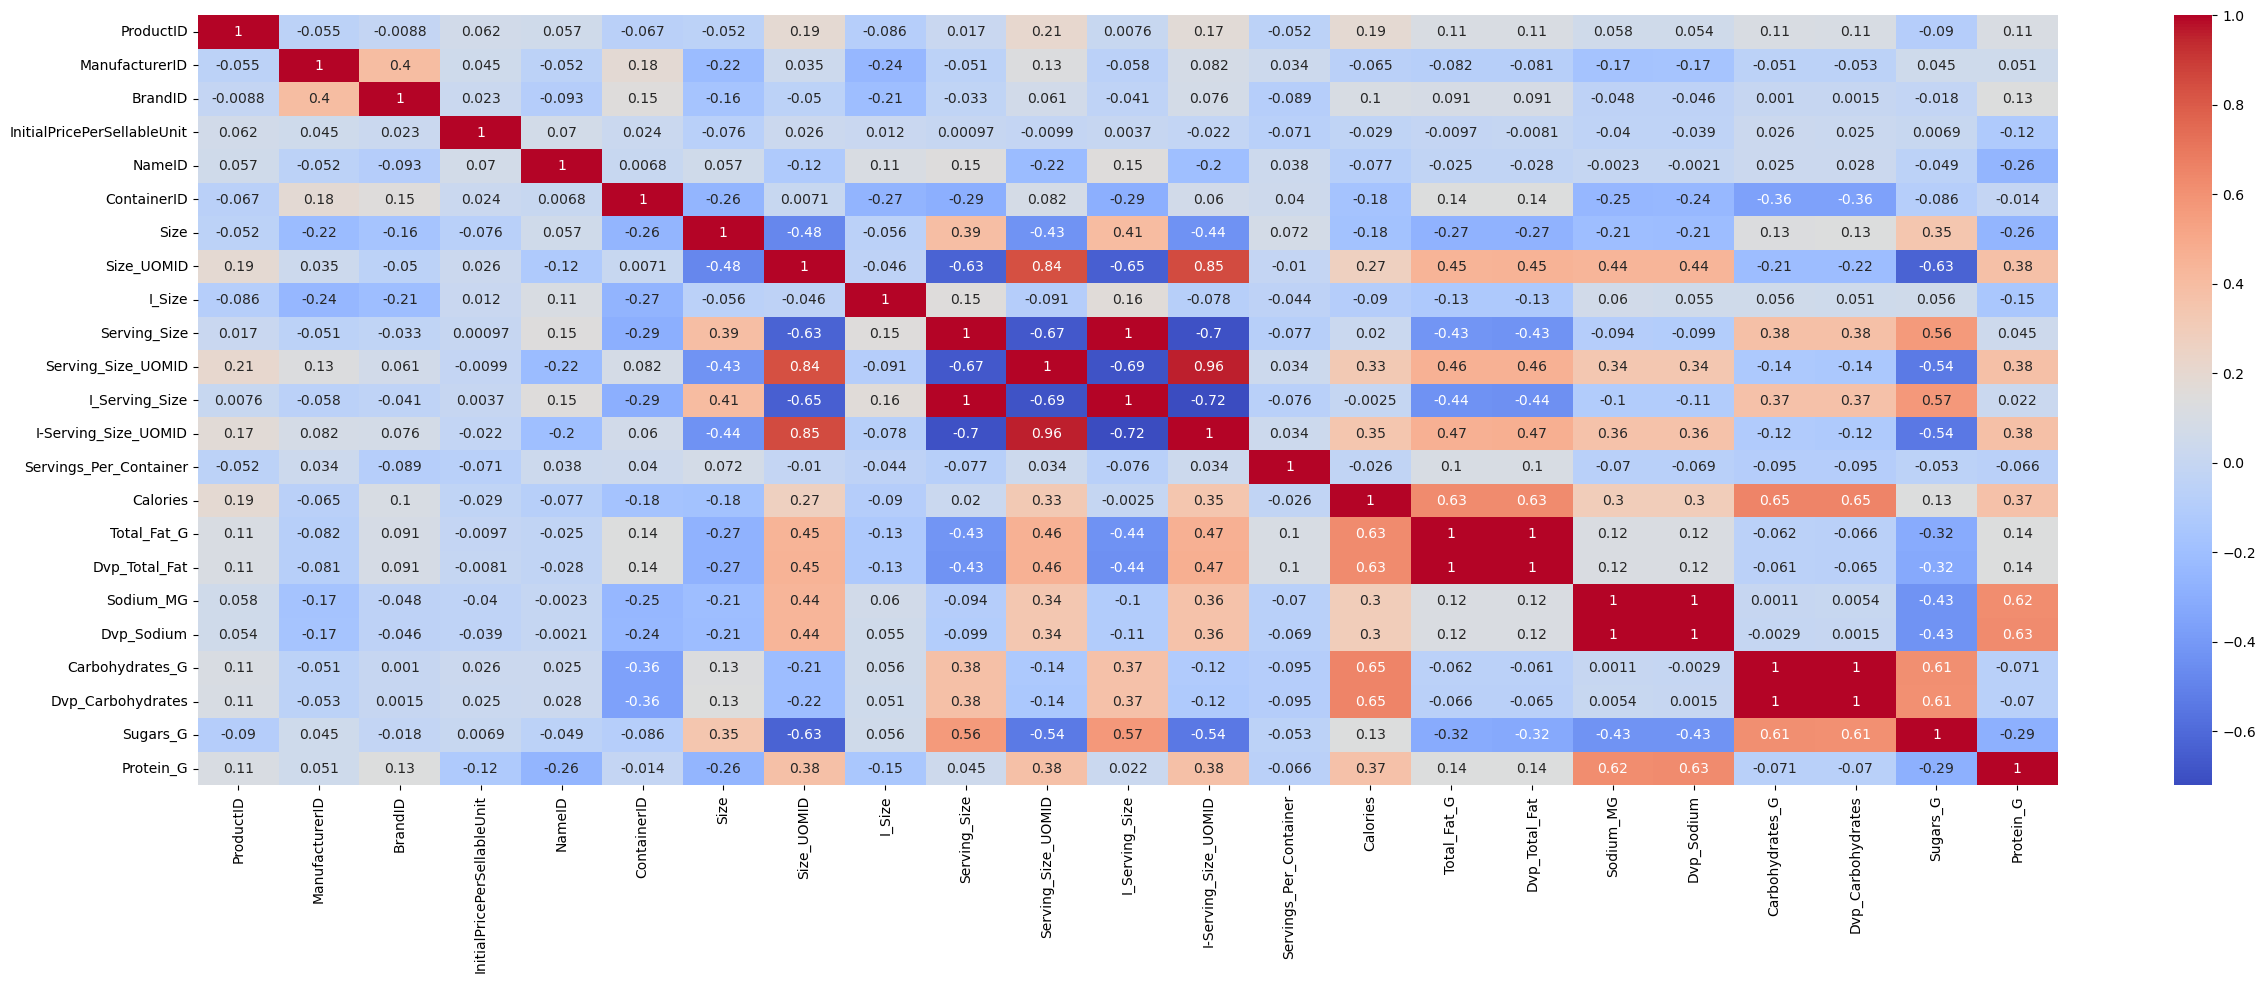

In [13]:
# Compute the correlation matrix
corr_matrix = ds.corr()

plt.figure(figsize=(30,10))


# Visualize the correlation matrix using a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')


### Considering the highest correlated attributes

In [14]:
new_df =ds[['Calories', 'Total_Fat_G','Carbohydrates_G']]

In [15]:
new_df.shape

(415, 3)

### Correlation with Calories

In [20]:
# Compute the correlation matrix
corr_matrix = new_df.corrwith(new_df["Calories"])

print(corr_matrix)


Calories           1.000000
Total_Fat_G        0.626419
Carbohydrates_G    0.654828
dtype: float64


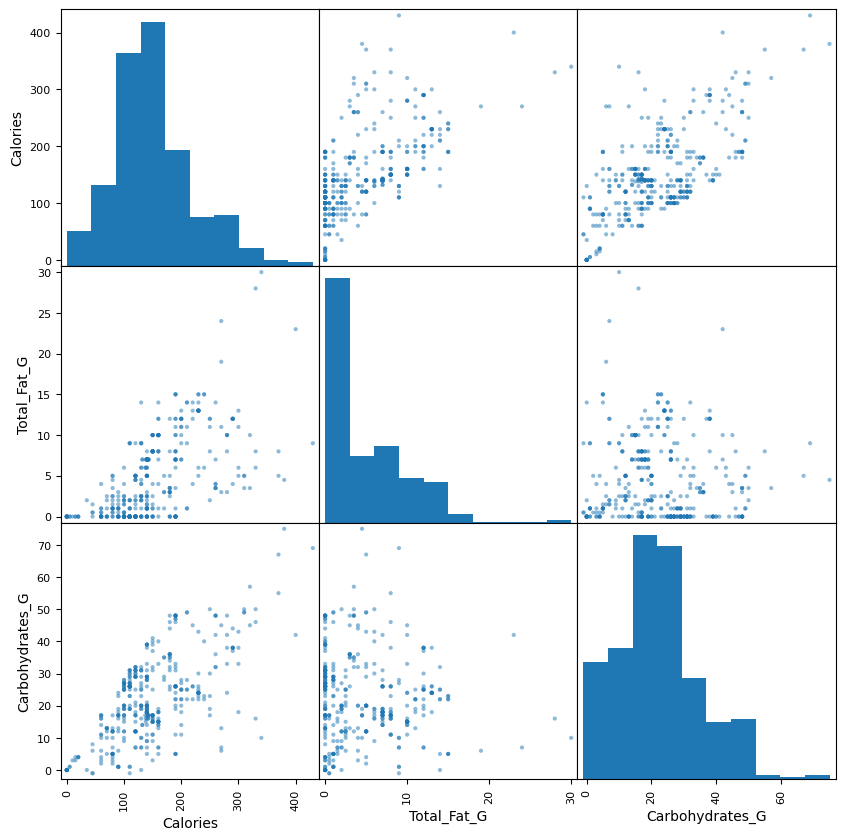

In [70]:
pd.plotting.scatter_matrix(new_df, figsize=(10, 10), diagonal='hist')

plt.show()

### Linear Regression

In [21]:
# Splitting the data
X = new_df[['Total_Fat_G','Carbohydrates_G']] 
y = new_df['Calories'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

# Fitting the model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Making predictions
y_pred = regressor.predict(X_test)

In [22]:
print("R2 score =", round(sm.r2_score(y_test, y_pred),2))

R2 score = 0.9


In [23]:
new_df.shape

(415, 3)

### Plotting Graphs with regression line

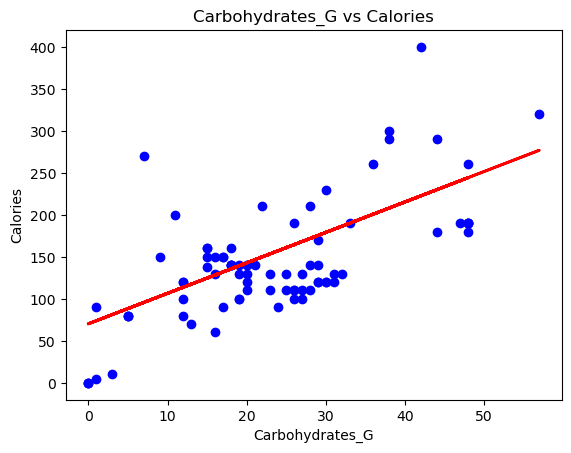

In [63]:
# Scatter plot for Carbohydrates_G with regression line
regressor.fit(X_train[['Carbohydrates_G']], y_train)
y_pred = regressor.predict(X_test[['Carbohydrates_G']])
plt.scatter(X_test['Carbohydrates_G'], y_test, color='blue')
plt.plot(X_test['Carbohydrates_G'], y_pred, color='red', linewidth=2)
plt.title('Carbohydrates_G vs Calories')
plt.xlabel('Carbohydrates_G')
plt.ylabel('Calories')
plt.show()

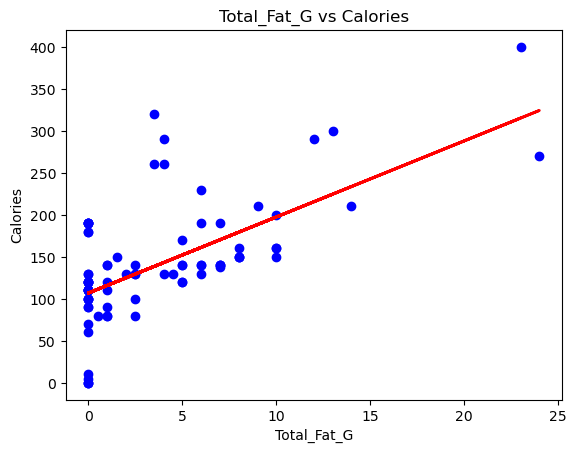

In [64]:
# Scatter plot for TotalFat_G with regression line
regressor.fit(X_train[['Total_Fat_G']], y_train)
y_pred = regressor.predict(X_test[['Total_Fat_G']])
plt.scatter(X_test['Total_Fat_G'], y_test, color='blue')
plt.plot(X_test['Total_Fat_G'], y_pred, color='red', linewidth=2)
plt.title('Total_Fat_G vs Calories')
plt.xlabel('Total_Fat_G')
plt.ylabel('Calories')
plt.show()

### Clustering

In [56]:
data_clus = ds[['Total_Fat_G', 'Sugars_G']]

In [57]:
data_clus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415 entries, 1 to 497
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Total_Fat_G  415 non-null    float64
 1   Sugars_G     415 non-null    float64
dtypes: float64(2)
memory usage: 9.7 KB


### Using Elbow Method to find number of clusters

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


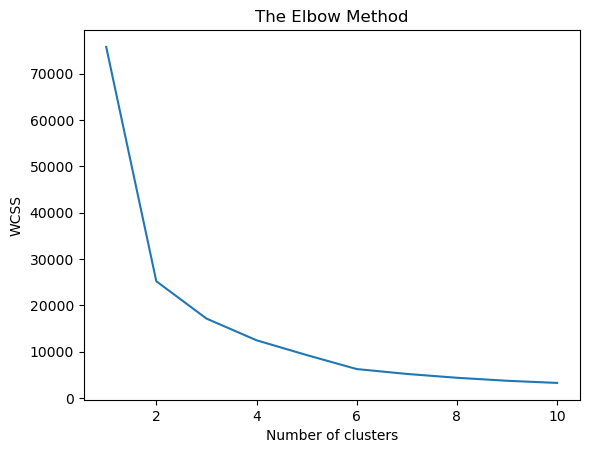

In [58]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(data_clus)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


### K-means clustering

In [60]:
# Load data into a pandas dataframe
X = data_clus[['Sugars_G', 'Total_Fat_G']]

# Define the number of clusters
k = 2

# Initialize k-means clustering
kmeans = KMeans(n_clusters=k)

# Fit the k-means model to the data
kmeans.fit(X)

# Get the cluster labels
labels = kmeans.labels_

# Add the cluster labels to the original dataframe
X['Cluster'] = labels


C:\Users\local_ranemu\Temp\ipykernel_16056\1665149125.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Cluster'] = labels


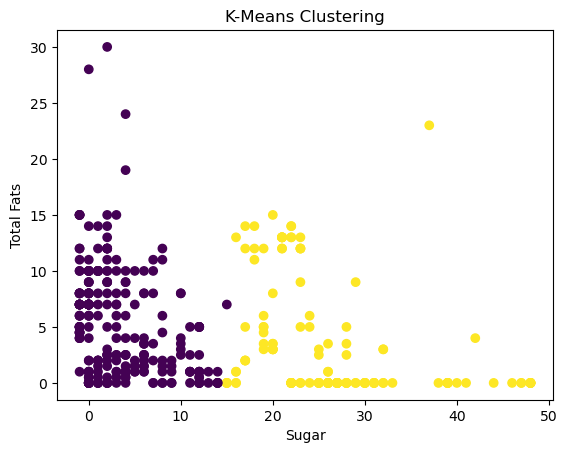

In [65]:
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=labels)
plt.xlabel('Sugar')
plt.ylabel('Total Fats')
plt.title('K-Means Clustering')
plt.show()